In [1]:
import matplotlib.pyplot as plt
import numpy as np
from multiprocess import Pool 

In [2]:
def main(s, max_iter, sequence=None, np=np):

    real_min = -2
    real_max = 1
    im_min = -1.2
    im_max = 1.2
    
    rng = np.random.default_rng(sequence)

    def generate_sample(s, real_min, real_max, im_min, im_max):
        
        real_arr =rng.uniform(real_min, real_max, size=s)
        im_arr = rng.uniform(im_min, im_max, size=s)

        complex_arr = np.zeros(s, dtype=complex)
        complex_list = list(complex_arr)
        for i in range(s):
            complex_list[i] = complex(real_arr[i], im_arr[i])

        return complex_list

    def f(z, c):
        return z**2 + c

    def iterate(c):
        iter = 0
        z = 0
        while abs(z) <= 2 and iter < max_iter:
            z = f(z, c)
            iter += 1
        return iter

    iterations = []
    for j in range(max_iter):
        iterations.append([]) 

    complex_list = generate_sample(s, real_min, real_max, im_min, im_max)
    for c in complex_list:
        iter = iterate(c)
        iterations[iter-1].append(c)

    # calculate area from fraction non-diverged points
    A = (real_max - real_min) * (im_max - im_min) * len(iterations[-1]) / s
    return iterations, A

In [131]:
if __name__ == "__main__":
    s_tot = 25000000
    n = 10
    s = int(s_tot / n)
    max_iter = 800
    max_iters = np.full(n, max_iter)
    s = np.full(n, s)

    seq = np.random.SeedSequence()
    seeds = seq.spawn(n)

    args = list(zip(s, max_iters, seeds))
    results = []
    area = []
    with Pool() as p:
        for result, A in p.starmap(main, args):
            results.append(result)
            area.append(A)
    
    print(area)
    mean = np.mean(area)
    std = np.std(area, ddof=1)
    error = 1.96*(std/np.sqrt(n))
    print(mean)
    print(mean - error, mean + error)
    # convert results to single list for faster plotting
    data = [None] * max_iter
    for subset in results:
        
        for it in range(len(subset)):
            try:
                data[it] += subset[it]
            except TypeError:
                data[it] = subset[it]

[1.9593499999999927e-05, 1.9588749999999927e-05, 1.9529749999999926e-05, 1.9544499999999924e-05, 1.9624249999999927e-05, 1.9496999999999925e-05, 1.9658999999999925e-05, 1.9701749999999924e-05, 1.9523499999999926e-05, 1.9552999999999926e-05]
1.9581499999999924e-05
1.9541303271774855e-05 1.9621696728224994e-05


In [140]:
def visualise(data, max_iter):
    fig = plt.figure(figsize=(3, 3), dpi=900)
    ax = fig.add_subplot(111)

    cmap = plt.cm.nipy_spectral_r
    norm = plt.Normalize(vmin=1, vmax=max_iter)
    plt.ylim(-0.6275, -0.6025)
    plt.xlim(0.1375, 0.1625)
    i = 0
    for it in data:
        i += 1
        x = np.real(np.array(it))
        y = np.imag(np.array(it))
        ax.scatter(x, y, lw=0, s=1.5*(72/fig.dpi)**2, color=cmap(norm(i)))
        # ax.scatter(x, y, lw=0, s=1, color=cmap(norm(i)))
        
    # fig.savefig('mandelbrot.png', dpi=300)
    plt.show()

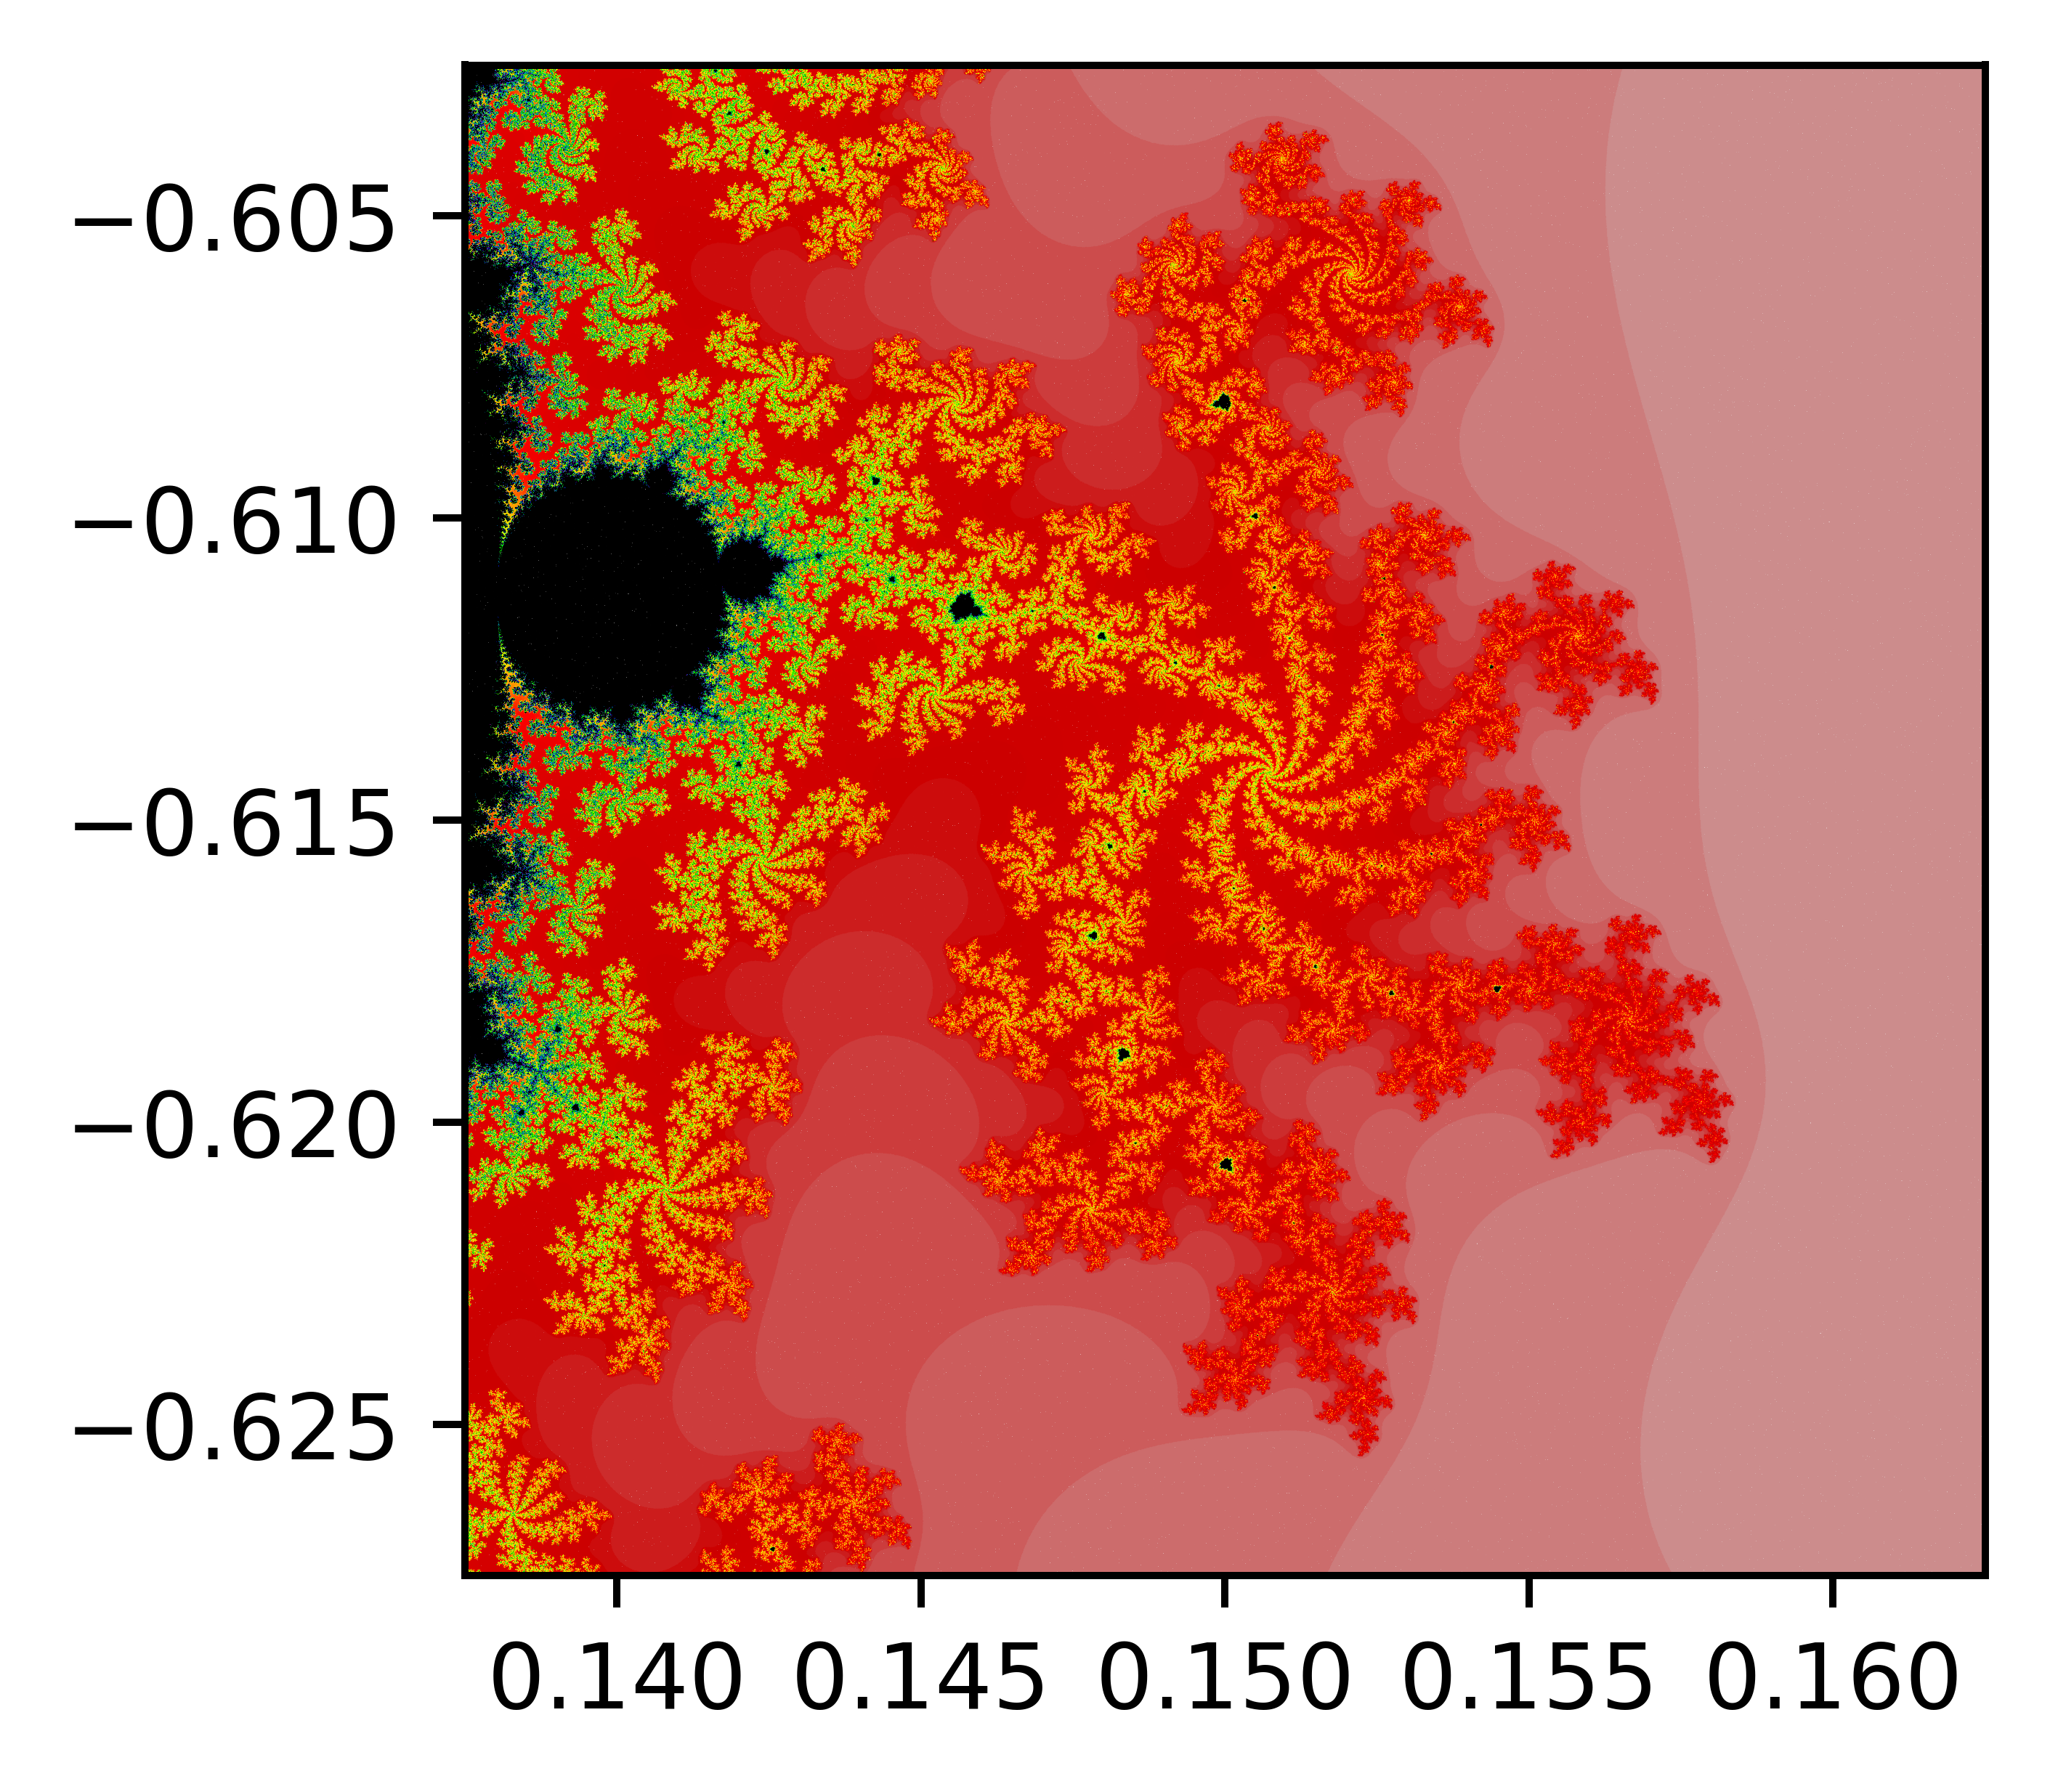

In [141]:
visualise(data, max_iter)

In [5]:
# runs main a number of times and finds mean and 95% conf. int
def loop(runs, s, max_iter, sequence, main=main):
    sub_sequence = sequence.spawn(10)
    area_list = []
    for i in range(runs):
        iterations, A = main(s, max_iter, sub_sequence[i])
        area_list.append(A)
    
    return area_list

In [33]:
if __name__ == "__main__":
    s = 10000
    chunks = 10
    runs = 5
    max_iter = 300
    max_iters = np.full(chunks, max_iter)
    s_list = np.full(chunks, s)
    runs_list = np.full(chunks, runs)

    # independent seeds necessary for parallel processing
    seq = np.random.SeedSequence()
    sequences = seq.spawn(chunks)


    args = list(zip(runs_list, s_list, max_iters, sequences))
    with Pool() as p:
        results =  p.starmap(loop, args)
    
    data = [None] * runs
    for chunk in results:
        for element in range(len(chunk)):
            try:
                data[element] += [chunk[element]]
            except TypeError:
                data[element] = [chunk[element]]
    

In [11]:
# this function finds the average for different number of max iter (and a fixed number of samples)
# run amount is the amount of runs we will find mean of

def converge_i(s, domain, sequence=None, main=main):
    difference = []
    upper = []
    lower = []

    data = []
    child_sequence = sequence.spawn(len(domain))
    
    for i in range(len(domain)):
        max_iter = domain[i]
        iterations, A = main(s, max_iter, child_sequence[i])
        data.append((max_iter, A))
    

    return data
# converge_i(10, 50, 550, 50)

In [19]:
if __name__ == "__main__":
    s = 500000
    chunks = 25
    
    min_iter = 100
    steps = 15
    max_iter = 1500
    
    max_iters = np.full(chunks, max_iter)
    s_list = np.full(chunks, s)
    # runs_list = list(np.full(chunks, runs))

    iter_range = np.linspace(min_iter, max_iter, steps, dtype=int)
    iter_ranges = np.repeat([iter_range], chunks, axis=0)
    # print(domains)

    # independent seeds necessary for parallel processing
    seq = np.random.SeedSequence()
    sequences = seq.spawn(chunks)
    
    args = list(zip(s_list, iter_ranges, sequences))
    
    with Pool() as p:
        results =  np.array(p.starmap(converge_i, args))
    
    data = [None] * steps
    for step in range(steps):
        data[step] = results[:,step, 1]
    print(data)    
        # print(results[chunk][]) 
        # data[chunk] = results[:,chunk, 1]
        # print(data[step])
        #     data[element] += [chunk[element]]
        # except TypeError:
        #     data[element] = [chunk[element]]
    
    # for row in data:
    #     print(row)


[array([1.5504336, 1.5508368, 1.5383376, 1.5480144, 1.5470928, 1.547064 ,
       1.5466032, 1.546272 , 1.5506208, 1.55304  , 1.5492528, 1.5437376,
       1.5482448, 1.553328 , 1.547496 , 1.5440688, 1.5505344, 1.551096 ,
       1.5463728, 1.5475968, 1.5510672, 1.552392 , 1.5506496, 1.5450624,
       1.5424704]), array([1.5291936, 1.5299424, 1.5293232, 1.5299568, 1.5326496, 1.5325056,
       1.5265584, 1.5283728, 1.5264   , 1.5231168, 1.5291504, 1.5275664,
       1.5292944, 1.5237072, 1.528344 , 1.5273072, 1.5242256, 1.5278112,
       1.5286896, 1.5224544, 1.5248448, 1.5239232, 1.5218928, 1.5302016,
       1.5229296]), array([1.5264576, 1.5182784, 1.5179616, 1.5178032, 1.5238224, 1.514952 ,
       1.5208128, 1.524744 , 1.5148368, 1.520064 , 1.529928 , 1.52172  ,
       1.5138   , 1.5156   , 1.524528 , 1.520856 , 1.5214032, 1.5201936,
       1.5206256, 1.5203088, 1.5182352, 1.5210288, 1.520856 , 1.5176016,
       1.5108768]), array([1.513224 , 1.5179328, 1.5141312, 1.5113232, 1.5147072, 1

In [39]:
def analyse(results, var_range):

    data = np.zeros((len(results), 6))

    for sim in range(len(results)):
        var = var_range[sim]
        min_area = np.min(results[sim])
        mean_area = np.mean(results[sim])

        max_area = np.max(results[sim])
        # print(f"Mean area = {mean_area}") 
        std = np.std(results[sim])  
        differ = 1.96 * std / (np.sqrt(len(results[sim])))
        # print(f"1.96 * standard error = {differ}")
        min_range = mean_area - differ
        max_range = mean_area + differ

        # print(f"range = [{min_range, max_range}]\n" )
        data[sim] = [var, min_area, mean_area, max_area, std, differ]
        print(mean_area)
        print(differ)
        print(mean_area - differ, mean_area + differ)
        
        print()


    print(data)    

    fig = plt.figure(figsize=(4,3), dpi = 300)
    x = data[:,0]/1000000
    y = data[:,2]
    yerr = data[:,-1]
    plt.plot(x,y, color = 'k')
    #plt.errorbar(x, y, yerr = yerr, color='k', ecolor = 'r', capsize = 5)
    plt.fill_between(x, y - yerr, y + yerr, color = 'g', alpha = 0.3)
    #plt.xlabel("Number of Iterations")
    plt.xlabel("Number of Samples (in millions)")
    plt.ylabel("Mean Area")
    plt.show()





    # print(area_list)
    # diff = mean_area - 0

    # std = np.std(area_list)
    # error = 1.96*std/(np.sqrt(run_amount))
    # min_range = mean_area - error
    # max_range = mean_area + error

    # difference.append(diff)
    # upper.append(min_range)
    # lower.append(max_range)
        
 


    

In [32]:
analyse(data, iter_range)

NameError: name 'iter_range' is not defined

In [3]:
# this function finds the average for different number of max iter (and a fixed number of samples)
# run amount is the amount of runs we will find mean of

def converge_s(s_range, max_iter, sequence=None, main=main):
    difference = []
    upper = []
    lower = []

    data = []
    child_sequence = sequence.spawn(len(s_range))
    
    for i in range(len(s_range)):
        s = s_range[i]
        iterations, A = main(s, max_iter, child_sequence[i])
        data.append((s, A))
    

    return data
# converge_i(10, 50, 550, 50)

In [41]:
if __name__ == "__main__":

    min_log_s = 100000
    max_log_s = 2500000
    steps = 15
    chunks = 25

    s_range = np.linspace(min_log_s, max_log_s, steps, dtype=int)
    s_ranges = np.repeat([s_range], chunks, axis=0)

    max_iter = 400
    max_iters = np.full(chunks, max_iter)
    # runs_list = list(np.full(chunks, runs))

    # independent seeds necessary for parallel processing
    seq = np.random.SeedSequence()
    sequences = seq.spawn(chunks)
    
    args = list(zip(s_ranges, max_iters, sequences))

    with Pool() as p:
        results =  np.array(p.starmap(converge_s, args))
    
    data = [None] * steps
    for step in range(steps):
        data[step] = results[:,step, 1]
        # print(results[chunk][]) 
        # data[chunk] = results[:,chunk, 1]
        # print(data[step])
        #     data[element] += [chunk[element]]
        # except TypeError:
        #     data[element] = [chunk[element]]
    
    # for row in data:
    #     print(row)


1.521684
0.008232419989286184
1.5134515800107138 1.5299164199892863

1.5155063999999998
0.00020955250881806676
1.5152968474911817 1.515715952508818

[[1.00000000e+05 1.51574400e+00 1.52168400e+00 1.52762400e+00
  5.94000000e-03 8.23241999e-03]
 [5.00000000e+06 1.51535520e+00 1.51550640e+00 1.51565760e+00
  1.51200000e-04 2.09552509e-04]]


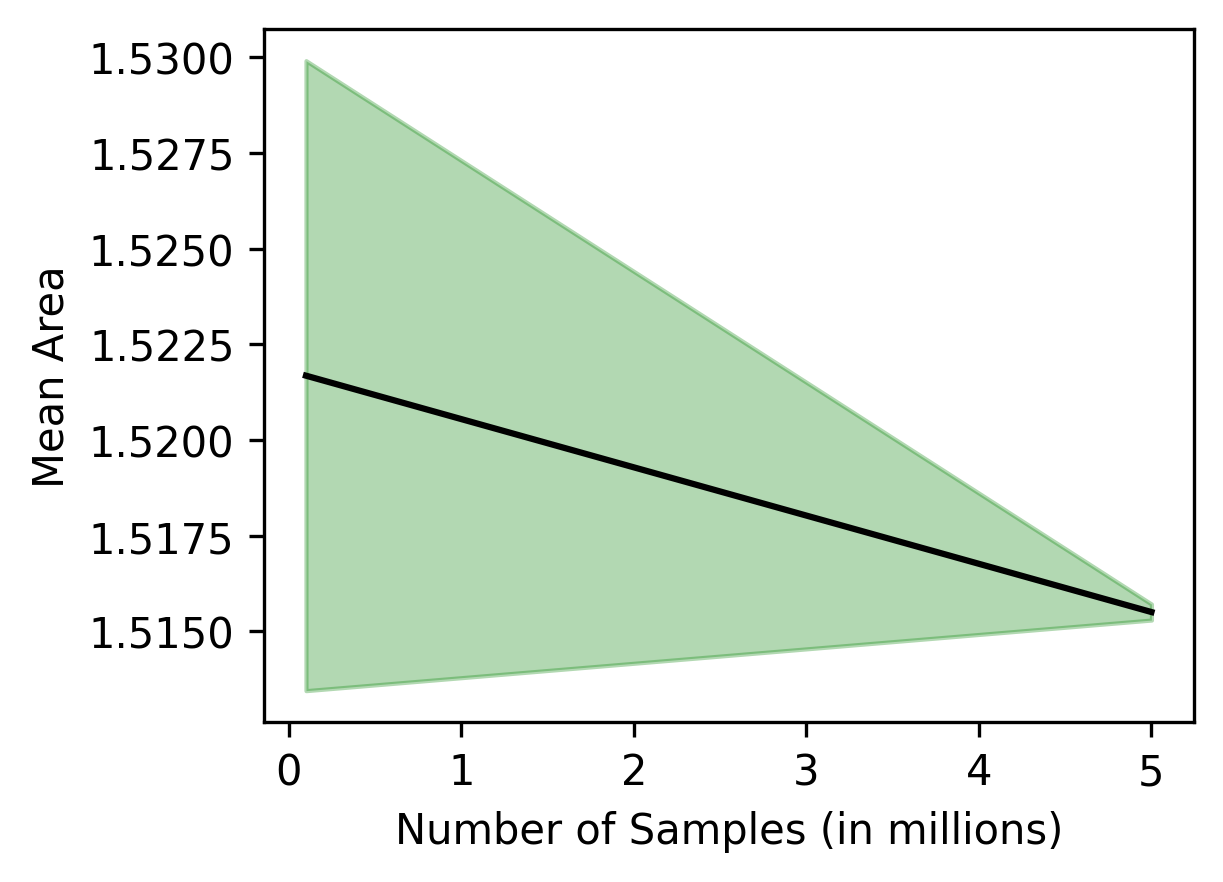

In [40]:
analyse(data, s_range)